In [230]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats, io
from scipy.special import expit

In [231]:
class LogisticRegressionModel(object):
    
    def __init__(self, name, seed = 42):
        if name != 'data':
            raise ValueError('Incorrect Dataset')
        np.random.seed(seed)
        self.name = name
        self.data = None
        self.trainOrig = None
        self.trLabelsOrig = None
        self.train = None
        self.trLabels = None
        self.val = None
        self.valLabels = None
        self.test = None
        self.dim = None
        self.weight = None
        self.pred = None
        
        self.load_data()
        self.split(1000)
        
    def load_data(self):
        self.data = io.loadmat(self.name + '.mat')
        print('Loaded: ' + self.name)
        self.normalize()
        self.trainOrig = self.data['X']
        self.trLabelsOrig = self.data['y'].reshape(-1)
        self.test  = self.data['X_test']
        self.test = np.apply_along_axis(self.add1, 1, self.test)
        
        print('Training size (Before Split): ' + str(len(self.trainOrig)))
        print('Training labels (Before Split):' + str(len(self.trLabelsOrig)))
        print('Test size: ' + str(len(self.test)))
        
        
    def split(self,valSize):
        totalLen = len(self.trainOrig)
        trainSize = totalLen - valSize
        randIdx = np.random.permutation(totalLen)
        self.train = self.trainOrig[randIdx][:trainSize]
        self.train = np.apply_along_axis(self.add1, 1, self.train)
        self.trLabels = self.trLabelsOrig[randIdx][:trainSize]
        self.val = self.trainOrig[randIdx][trainSize:]
        self.val = np.apply_along_axis(self.add1, 1, self.val)
        self.valLabels = self.trLabelsOrig[randIdx][trainSize:]
        self.dim = self.train.shape
        
        print('Training Data Len: ' + str(len(self.train)))
        print('Training Labels Len: ' + str(len(self.trLabels)))
        print('Validation Data Len: ' + str(len(self.val)))
        print('Validation Labels Len: ' + str(len(self.valLabels)))

    def normalize(self):
        for idx in ['X', 'X_test']:
            mean = np.mean(self.data[idx], axis = 0)
            std = np.std(self.data[idx], axis = 0)
            z_score = lambda val: (val-mean)/std
            self.data[idx] = np.apply_along_axis(z_score,1,self.data[idx])

    def add1(self, arr):
        return np.append(arr, [[1]])
    
    def cost(self,X,y,w,l):
        s = expit(X @ w)
        s = np.maximum(s, 1e-7)
        s = np.minimum(s, 1-1e-7)
        return l*w@w - (1/len(X))*(y.dot(np.log(s)) + (1-y).dot(np.log(1-s)))
    
    def grad_penalty(self,X,y,w,l):
        s = expit(X @ w)
        return -X.T.dot(y - s) + 2*l*w
        
    def gradient_descent(self,typeGrad,e,l,changingE,tol=1e-7,graph=True,numIter=1000,maxLoops = 5):
        costLst, valCost = [], []
        converged = False
        w = np.zeros(self.dim[1])
        J_o, J_new = float("Inf"), self.cost(self.train, self.trLabels, w, l)
        i = 0
        if typeGrad == 'batch':
            while i < numIter and not converged:
                w = w - e * self.grad_penalty(self.train, self.trLabels, w, l)
                J_o, J_new = J_new, self.cost(self.train, self.trLabels, w, l)      
                costLst.append(J_o)
                valCost.append(self.cost(self.val, self.valLabels, w, l))
                i+=1
                if abs(J_o - J_new) < tol:
                    converged = True
                    break
        if typeGrad == 'stochastic':
            numLoops = 0
            while numLoops < maxLoops and not converged:
                numLoops += 1
                randIdx = np.random.permutation(self.dim[0])
                X = self.train[randIdx]
                y = self.trLabels[randIdx]
                for x_i, y_i in zip(X, y):
                    if changingE:
                        w = w - e/(.03*(i+10)) * self.grad_penalty(x_i, y_i, w, l)
                    else:
                        w = w - e*self.grad_penalty(x_i, y_i, w, l)
                    J_o, J_new = J_new, self.cost(X, y, w, l)
                    costLst.append(J_o)
                    valCost.append(self.cost(self.val, self.valLabels, w, l))
                    i+=1
                    if abs(J_o - J_new) < tol:
                        converged = True
                        break
        print("Cost Final: " + str(J_o))
        print("Converged:" + str(i) + "iterations")
        if graph:
            plt.plot(costLst, label = "Training")
            plt.plot(valCost, label = "Validation")
            plt.xlabel("Number of Iterations")
            plt.ylabel("Cost")
            plt.title("Cost Over Iterations")
        self.weight = w
    

    def experiment(self,typeGrad,testData,e,l,changingE):
        self.gradient_descent(typeGrad,e,l,changingE,graph=False)
        y_val = expit(testData @ self.weight)
        y_pred = (y_val > 0.5).astype(np.int)
        self.pred = y_pred
        return y_pred
    
    def accuracy(self,labels):
        return np.sum(self.pred.reshape(-1) == labels.reshape(-1))/len(self.pred)                
                
        
        

Loaded: data
Training size (Before Split): 6000
Training labels (Before Split):6000
Test size: 497
Training Data Len: 5000
Training Labels Len: 5000
Validation Data Len: 1000
Validation Labels Len: 1000
Cost Final: 0.03451128789693964
Converged:208iterations


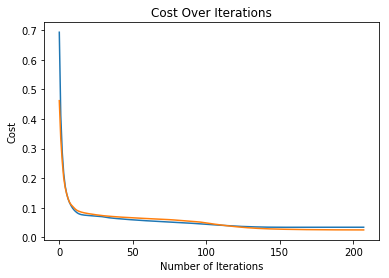

In [238]:
m = LogisticRegressionModel('data', 42)
m.gradient_descent('batch', .01, 1e-6, changingE = False)

In [234]:
lrs = [10**(-7), 10**(-6), 10**(-5), 10**(-4), 10**(-3), 10**(-2)]
regs = [.01,.001,.0001,.00001,.000001,.0000001]
for lr in lrs:
    for reg in regs:
        mod = LogisticRegressionModel('data', 42)
        mod.experiment('batch', mod.val, lr, reg, changingE = False)
        print("LR: "+str(lr)+'  RegParam: '+str(reg)+ '  Accuracy: '+ str(mod.accuracy(mod.valLabels)))



Loaded: data
Training size (Before Split): 6000
Training labels (Before Split):6000
Test size: 497
Training Data Len: 5000
Training Labels Len: 5000
Validation Data Len: 1000
Validation Labels Len: 1000
Cost Final: 0.5129414392036031
Converged:1000iterations
LR: 1e-07  RegParam: 0.01  Accuracy: 0.962
Loaded: data
Training size (Before Split): 6000
Training labels (Before Split):6000
Test size: 497
Training Data Len: 5000
Training Labels Len: 5000
Validation Data Len: 1000
Validation Labels Len: 1000
Cost Final: 0.5121343753396624
Converged:1000iterations
LR: 1e-07  RegParam: 0.001  Accuracy: 0.962
Loaded: data
Training size (Before Split): 6000
Training labels (Before Split):6000
Test size: 497
Training Data Len: 5000
Training Labels Len: 5000
Validation Data Len: 1000
Validation Labels Len: 1000
Cost Final: 0.5120536688016132
Converged:1000iterations
LR: 1e-07  RegParam: 0.0001  Accuracy: 0.962
Loaded: data
Training size (Before Split): 6000
Training labels (Before Split):6000
Test si

Cost Final: 0.035192866625506684
Converged:1000iterations
LR: 0.001  RegParam: 1e-05  Accuracy: 0.997
Loaded: data
Training size (Before Split): 6000
Training labels (Before Split):6000
Test size: 497
Training Data Len: 5000
Training Labels Len: 5000
Validation Data Len: 1000
Validation Labels Len: 1000
Cost Final: 0.03462706691031586
Converged:1000iterations
LR: 0.001  RegParam: 1e-06  Accuracy: 0.997
Loaded: data
Training size (Before Split): 6000
Training labels (Before Split):6000
Test size: 497
Training Data Len: 5000
Training Labels Len: 5000
Validation Data Len: 1000
Validation Labels Len: 1000
Cost Final: 0.03457048635840218
Converged:1000iterations
LR: 0.001  RegParam: 1e-07  Accuracy: 0.997
Loaded: data
Training size (Before Split): 6000
Training labels (Before Split):6000
Test size: 497
Training Data Len: 5000
Training Labels Len: 5000
Validation Data Len: 1000
Validation Labels Len: 1000
Cost Final: 0.8000429683031589
Converged:963iterations
LR: 0.01  RegParam: 0.01  Accura

In [240]:
#Cell for submission
m = LogisticRegressionModel('data', 42)
y_pred = m.experiment('batch', m.test, .01, 1e-6, changingE = False).reshape(-1)

def results_to_csv(y_test):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  # Ensures that the index starts at 1. 
    df.to_csv('submission.csv', index_label='Id')

results_to_csv(y_pred)



Loaded: data
Training size (Before Split): 6000
Training labels (Before Split):6000
Test size: 497
Training Data Len: 5000
Training Labels Len: 5000
Validation Data Len: 1000
Validation Labels Len: 1000
Cost Final: 0.03451128789693964
Converged:208iterations
